In [3]:
#load dataset
import pandas as pd
import numpy as np
import joblib
import pickle
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

# Load dataset
data = pd.read_csv(r"C:\Users\natra\Downloads\ML dataset\loan_data_1.csv")

# Drop unnecessary columns
if 'Loan_ID' in data.columns:
    data.drop(columns=['Loan_ID'], inplace=True)

if 'serial_no' in data.columns:
    data.drop(columns=['serial_no'], inplace=True)

# Handle missing values
data.dropna(inplace=True)

# Encode categorical variables
data = pd.get_dummies(data, drop_first=True)

# Ensure 'Loan_Status' exists and is binary
if 'Loan_Status_Y' not in data.columns:
    raise KeyError("Loan_Status column is missing!")

# Define features and target
X = data.drop(columns=['Loan_Status_Y'])  # Features
y = data['Loan_Status_Y']  # Target

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mutual Information for Feature Selection
mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
feature_ranking = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)

# Dynamically adjust selection threshold (Top 30% Features)
threshold = feature_ranking.quantile(0.3)
selected_features = feature_ranking[feature_ranking > threshold].index
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print("\n📌 Selected Features Before Training:")
print(list(selected_features))

# Define model
clf = XGBClassifier(random_state=42)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 300, 500, 800],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Grid Search
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_selected, y_train)

# Best parameters
best_params = grid_search.best_params_



# Train Final Model with Best Parameters
best_model = XGBClassifier(**best_params, random_state=42)
best_model.fit(X_train_selected, y_train)

# Feature Importance Before Pruning
feature_importance = pd.Series(best_model.feature_importances_, index=selected_features)
print("\n📊 Feature Importances Before Pruning:")
print(feature_importance.sort_values(ascending=False))

# Pruning Mechanism: Remove Low-Importance Features (<3%)
low_importance_features = feature_importance[feature_importance < 0.03].index

if len(low_importance_features) > 0:
    print("\n✂ Pruning Features (Low Importance <3%):")
    print(list(low_importance_features))
    selected_features = selected_features.drop(low_importance_features, errors='ignore')

# Retrain with Pruned Features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
best_model.fit(X_train_selected, y_train)

# Feature Importance After Pruning
feature_importance = pd.Series(best_model.feature_importances_, index=selected_features)
print("\n📊 Feature Importances After Pruning:")
print(feature_importance.sort_values(ascending=False))

# Save selected features for future use
joblib.dump(selected_features, "selected_features7.pkl")

# Save the trained model
joblib.dump(best_model, "loan_approval_model7.pkl")
print("\nModel saved as 'loan_approval_model7.pkl' and selected features saved as 'selected_features7.pkl'.")

# Predict and evaluate
y_pred = best_model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Final Model Accuracy After Pruning: {accuracy * 100:.2f}%")



📌 Selected Features Before Training:
['Credit_History', 'LoanAmount', 'ApplicantIncome', 'CoapplicantIncome', 'Loan_Amount_Term', 'Dependents_2', 'Property_Area_Urban', 'Property_Area_Semiurban', 'Gender_Male', 'Education_Not Graduate']
Fitting 5 folds for each of 256 candidates, totalling 1280 fits

📊 Feature Importances Before Pruning:
Credit_History             0.495944
Property_Area_Urban        0.093932
Property_Area_Semiurban    0.085064
Loan_Amount_Term           0.059276
Education_Not Graduate     0.052124
CoapplicantIncome          0.050662
ApplicantIncome            0.050411
Dependents_2               0.049554
LoanAmount                 0.036972
Gender_Male                0.026060
dtype: float32

✂ Pruning Features (Low Importance <3%):
['Gender_Male']

📊 Feature Importances After Pruning:
Credit_History             0.520128
Property_Area_Urban        0.097648
Property_Area_Semiurban    0.076996
Loan_Amount_Term           0.061252
CoapplicantIncome          0.054164
Applican

In [13]:
import joblib
import pandas as pd

# Load the trained model and selected features
clf = joblib.load("loan_approval_model.pkl")
selected_features = joblib.load("selected_features.pkl")

# Function to get user input
def get_user_input():
    print("Enter loan application details:")
    
    # Define feature names (replace with actual feature names if needed)
    input_data = {}
    for feature in selected_features:
        value = input(f"Enter value for {feature}: ")
        try:
            input_data[feature] = float(value)  # Convert numeric values
        except ValueError:
            input_data[feature] = value  # Keep as string if not numeric

    # Convert to DataFrame
    input_df = pd.DataFrame([input_data])

    # Handle categorical features (ensure all required columns exist)
    for feature in selected_features:
        if feature not in input_df.columns:
            input_df[feature] = 0  # Assign default value if missing
    
    return input_df[selected_features]  # Return only selected features

# Get user input
new_data = get_user_input()

# Predict
prediction = clf.predict(new_data)[0]

# Interpret prediction
result = "Approved" if prediction == 1 else "Rejected"
print(f"Loan Status Prediction: {result}")


Enter loan application details:


Enter value for Credit_History:  1
Enter value for LoanAmount:  114
Enter value for ApplicantIncome:  1853
Enter value for CoapplicantIncome:  2840
Enter value for Loan_Amount_Term:  360
Enter value for Dependents_2:  0
Enter value for Property_Area_Urban:  0
Enter value for Property_Area_Semiurban:  0
Enter value for Education_Not Graduate:  0


Loan Status Prediction: Rejected


Selected Features Before Training: ['Atmospheric Pressure', 'Precipitation (%)', 'Temperature', 'Visibility (km)', 'UV Index', 'Humidity', 'Season_Winter', 'Cloud Cover_overcast', 'Wind Speed']

Feature Importance Before Pruning:
 UV Index                0.258429
Temperature             0.251019
Precipitation (%)       0.122809
Season_Winter           0.113498
Visibility (km)         0.109982
Atmospheric Pressure    0.051063
Cloud Cover_overcast    0.035961
Humidity                0.030550
Wind Speed              0.026688
dtype: float32

Feature Importance After Pruning:
 UV Index                0.258429
Temperature             0.251019
Precipitation (%)       0.122809
Season_Winter           0.113498
Visibility (km)         0.109982
Atmospheric Pressure    0.051063
Cloud Cover_overcast    0.035961
Humidity                0.030550
Wind Speed              0.026688
dtype: float32

Final Accuracy After Pruning: 91.25%


C:\Users\natra\AppData\Local\Temp\ipykernel_24160\1165618442.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y_train_distribution.index, y=y_train_distribution.values, ax=axes[0], palette="Blues")
C:\Users\natra\AppData\Local\Temp\ipykernel_24160\1165618442.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y_test_distribution.index, y=y_test_distribution.values, ax=axes[1], palette="Greens")


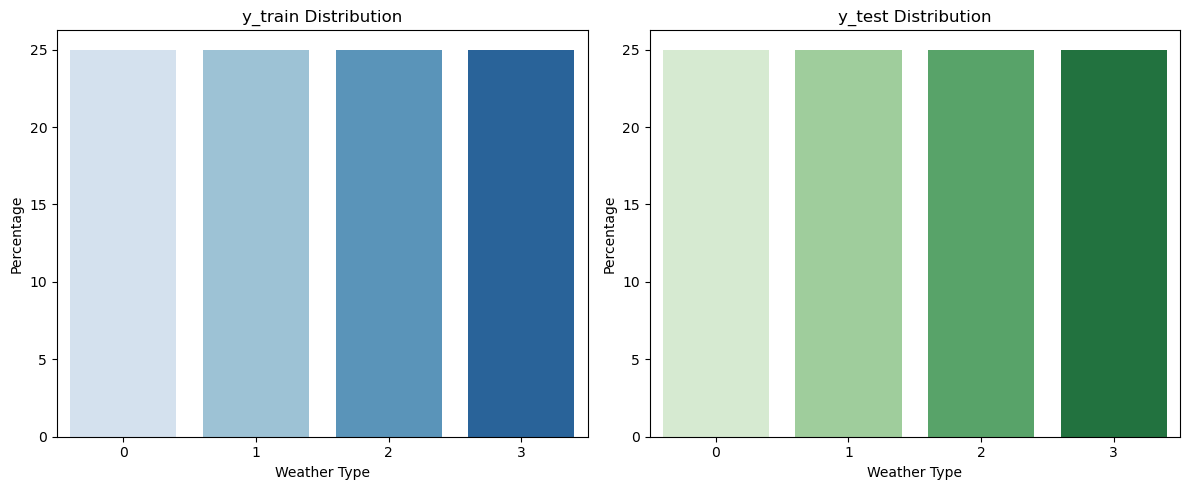

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import joblib

# Load dataset
file_path = r"C:\Users\natra\Downloads\ML dataset\weather_classification_data.csv"
data = pd.read_csv(file_path)

# Encode 'Weather Type' to numerical labels
data['Weather Type'] = data['Weather Type'].astype('category')
weather_labels = dict(enumerate(data['Weather Type'].cat.categories))
data['Weather Type'] = data['Weather Type'].cat.codes

# Encode categorical features ('Cloud Cover' and 'Season') using One-Hot Encoding
categorical_features = ['Cloud Cover', 'Season', 'Location']
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

# Define features and target
X = data.drop(columns=['Weather Type'])
y = data['Weather Type']

# Split into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Mutual Information for Feature Selection
mi_scores = mutual_info_classif(X_train, y_train, discrete_features=False)
feature_ranking = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)

# Select Top 60% Features (More than before)
threshold = feature_ranking.quantile(0.4)  # Keep more features
selected_features = feature_ranking[feature_ranking > threshold].index
print(f"Selected Features Before Training: {selected_features.tolist()}")

# Train XGBoost Classifier with Optimized Hyperparameters
clf = XGBClassifier(
    n_estimators=500,  # More estimators
    learning_rate=0.01,  # Slower learning rate
    max_depth=12,  # Increased depth for better feature interactions
    min_child_weight=2,
    gamma=5,  # Regularization
    subsample=0.8,  # Slightly lower for regularization
    colsample_bytree=0.8,
    reg_lambda=2,  # L2 regularization
    objective='multi:softmax',
    num_class=len(weather_labels),
    random_state=42
)
clf.fit(X_train[selected_features], y_train)

# Feature importance before pruning
feature_importance_before = pd.Series(clf.feature_importances_, index=selected_features)
print("\nFeature Importance Before Pruning:\n", feature_importance_before.sort_values(ascending=False))

# Pruning Mechanism: Remove Very Low-Importance Features
low_importance_features = feature_importance_before[feature_importance_before < 0.02].index

if len(low_importance_features) > 0:
    print(f"\nPruning Features: {low_importance_features.tolist()}")
    selected_features = selected_features.drop(low_importance_features, errors='ignore')

# Retrain with Pruned Features
clf.fit(X_train[selected_features], y_train)

# Feature importance after pruning
feature_importance_after = pd.Series(clf.feature_importances_, index=selected_features)
print("\nFeature Importance After Pruning:\n", feature_importance_after.sort_values(ascending=False))

# Predict and evaluate
y_pred = clf.predict(X_test[selected_features])
accuracy = accuracy_score(y_test, y_pred)
print(f'\nFinal Accuracy After Pruning: {accuracy * 100:.2f}%')

# Save Model & Selected Features
joblib.dump(clf, "weather_classification_model3.pkl")
joblib.dump(selected_features.tolist(), "selected_features_weather3.pkl")
joblib.dump(weather_labels, "weather_labels3.pkl")

# Debugging: Check class distribution
y_train_distribution = y_train.value_counts(normalize=True) * 100
y_test_distribution = y_test.value_counts(normalize=True) * 100

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(x=y_train_distribution.index, y=y_train_distribution.values, ax=axes[0], palette="Blues")
sns.barplot(x=y_test_distribution.index, y=y_test_distribution.values, ax=axes[1], palette="Greens")

axes[0].set_title("y_train Distribution")
axes[0].set_xlabel("Weather Type")
axes[0].set_ylabel("Percentage")

axes[1].set_title("y_test Distribution")
axes[1].set_xlabel("Weather Type")
axes[1].set_ylabel("Percentage")

plt.tight_layout()
plt.show()


In [25]:
import pandas as pd
import joblib
import numpy as np

# Load saved model and selected features
model = joblib.load("weather_classification_model3.pkl")
selected_features = joblib.load("selected_features_weather3.pkl")
weather_labels = joblib.load("weather_labels3.pkl")

# Function to preprocess user input
def preprocess_input(user_data):
    # Convert to DataFrame
    df = pd.DataFrame([user_data])

    # Ensure categorical encoding matches training
    categorical_features = ['Cloud Cover', 'Season']
    df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

    # Add missing columns if any (for consistency)
    for col in selected_features:
        if col not in df:
            df[col] = 0  # Assign 0 for missing categorical features

    # Ensure correct column order
    df = df[selected_features]
    return df

# Function to make a prediction
def predict_weather(user_input):
    processed_input = preprocess_input(user_input)
    prediction = model.predict(processed_input)[0]
    return weather_labels[prediction]

# Example User Input
user_input = {
    "Temperature": 30,
    "Humidity": 64,
    "Wind Speed": 7,
    "Precipitation (%)": 16,
    "Cloud Cover": "clear",  # Ensure this matches training data values
    "Atmospheric Pressure": 1018.72,
    "UV Index": 5,
    "Season": "spring",
    "Visibility (km)": 5.5}

# Get Prediction
predicted_weather = predict_weather(user_input)
print(f"Predicted Weather Type: {predicted_weather}")


Predicted Weather Type: Sunny


In [ ]:
#sample input values 

#rainy
"Temperature": 14,
    "Humidity": 73,
    "Wind Speed": 9.5,
    "Precipitation (%)": 82,
    "Cloud Cover": "partly cloudy",  # Ensure this matches training data values
    "Atmospheric Pressure": 1010.82,
    "UV Index": 2,
    "Season": "winter",
    "Visibility (km)": 3.5

#sunny
    "Temperature": 30,
    "Humidity": 64,
    "Wind Speed": 7,
    "Precipitation (%)": 16,
    "Cloud Cover": "clear",  # Ensure this matches training data values
    "Atmospheric Pressure": 1018.72,
    "UV Index": 5,
    "Season": "spring",
    "Visibility (km)": 5.5
#cloudy
 "Temperature": 33,
    "Humidity": 55,
    "Wind Speed": 3.5,
    "Precipitation (%)": 26,
    "Cloud Cover": "overcast",  # Ensure this matches training data values
    "Atmospheric Pressure": 1010.03,
    "UV Index": 2,
    "Season": "summer",
    "Visibility (km)": 5
#snowy
"Temperature": 3,
    "Humidity": 85,
    "Wind Speed": 6,
    "Precipitation (%)": 96,
    "Cloud Cover": "partly cloud",  # Ensure this matches training data values
    "Atmospheric Pressure": 984.46,
    "UV Index": 1,
    "Season": "winter",
    "Visibility (km)": 3.5